Задание:

Выполните классификацию текста на данных. Твиты были взяты из Twitter, после чего была проведена ручная разметка. Имена и фамилии пользователей были закодированы, чтобы избежать проблем с конфиденциальностью.

На основе jupyter notebook из воркшопа выполните задание:

1. Изучите представленные данные.
В качестве обучения и тестирования моделей возьмите тренировочную выборку (train), а в качестве тестовой (для итоговой модели) возьмите test.
Ваша задача — предсказать Sentiment (тональность) текста OriginalTweet.
Результат — модель, которая предсказывает 3 различные метки: Negative, Positive, Neutral. (Extremely Positive/Negative можно заменить на Positive/Negative).

2. Подготовьте данные (стоп-слова, название аккаунта твиттера, хэштеги и т.п. все что посчитаете необходимым).

3. Выберите оптимальное количество эпох и поэкспериментируйте:

различные эмбеддинги (в качестве входных эмбеддингов можно использовать любые представленные в Gensim);
разный размер длины входящей последовательности;
различные архитектуры (виды сетей, одно-двунаправленность, количество слоев, размер скрытого состояния, регуляризация и т.д.);
разные оптимизаторы и learning rate оптимизатора.
4. Оцените скорость обучения, метрики качества обученных моделей и сделайте выводы.
Для оценки качества, во время экспериментов, можно создать валидационную выборку из тренировочной, оптимальный размер — ~10% от тренировочной (можно подобрать самим).

5. Выберите итоговую модель и оцените метрику качества на тестовой выборке.
В качестве метрики используйте Macro F1 (усреднение F1 по каждому классу).
Приемлемое качество macro F1 — 0.7 (от заказчика).

6. На проверку пришлите ваш jupyter notebook с исследованием.

**Наша цель** - добиться требуемого значения метрики точности, используя любой из видов RNN.

Установим и импортируем необходимые бибилиотеки.

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 69.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import gensim
import gensim.downloader as api
import nltk

import warnings
warnings.filterwarnings('ignore')

Импортируем датасеты, с которыми будем работать. Сразу по допуску в задании заменим "Extremely Negative' и 'Extremely Positive' на "Negative" и "Positive". В итоге у нас получаются 3 класса в "Sentiment".

In [ ]:
df_train = pd.read_csv('Corona_NLP_train.csv', encoding='latin1')
df_test = pd.read_csv('Corona_NLP_test.csv', encoding='latin1')

In [ ]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df_train['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [ ]:
df_train['Sentiment'] = df_train['Sentiment'].replace({
    'Extremely Positive': 'Positive',
    'Extremely Negative': 'Negative'
})

df_test['Sentiment'] = df_test['Sentiment'].replace({
    'Extremely Positive': 'Positive',
    'Extremely Negative': 'Negative'
})

In [ ]:
df_train['Sentiment'].unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

Подготовим данные: вначале посмотрим на пропущенные значения.

In [ ]:
df_train.isna().sum()

,0
UserName,0
ScreenName,0
Location,8590
TweetAt,0
OriginalTweet,0
Sentiment,0


Много пропущенных значений в поле Location, что логично, потому что часто в социальном пространстве люди игнорируют это поле в анкетах, профилях и тд. Хотя, конечно, это поле не так важно для будущего датасета, уберем все Nan. Так как здесь Nan, по факту, обозначет осутсвие информации о городе, заменим их на Unknown.

In [ ]:
df_train['Location'] = df_train['Location'].fillna('Unknown')
df_test['Location'] = df_test['Location'].fillna('Unknown')

In [ ]:
df_train.isna().sum()

,0
UserName,0
ScreenName,0
Location,0
TweetAt,0
OriginalTweet,0
Sentiment,0


Вообще, этап в следующих двух ячейках появился на самом последнем шаге подготовки данных, когда я заметила битые символы в столбцах из-за неточностей перекодировки при считывании датасета. Конечно, исправлять текст,повреждённый проблемами с кодировкой, лучше в начале работы с этим текстом.

In [ ]:
!pip install ftfy
import ftfy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.9 MB/s eta 0:00:00


In [ ]:
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(ftfy.fix_text)
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(ftfy.fix_text)

df_train['Location'] = df_train['Location'].apply(ftfy.fix_text)
df_test['Location'] = df_test['Location'].apply(ftfy.fix_text)

В основном работать мы будем со столбцом OriginalTweet, который станет набором данных для обучения RNN. Приведем весь текст к нижнему регистру, удалим ссылки, упоминания (@) и хештеги из твитов.

In [ ]:
df_train['OriginalTweet'] = df_train['OriginalTweet'].str.lower()
df_test['OriginalTweet'] = df_test['OriginalTweet'].str.lower()

In [ ]:
import re

df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x))
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x))

In [ ]:
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(lambda x: re.sub(r'@\w+', '', x))
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(lambda x: re.sub(r'@\w+', '', x))

In [ ]:
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(lambda x: re.sub(r'#', '', x))
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(lambda x: re.sub(r'#', '', x))

Уберем пустые твиты, если они есть, а также удалим из них стоп слова (на английском языке), предварительно загрузив список из нужной библиотеки.

In [ ]:
df_train = df_train[df_train['OriginalTweet'].str.len()!=0]
df_test = df_test[df_train['OriginalTweet'].str.len()!=0]

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

In [ ]:
df_train.head(15)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,,Neutral
1,3800,48752,UK,16-03-2020,advice talk neighbours family exchange phone n...,Positive
2,3801,48753,Vagabonds,16-03-2020,coronavirus australia: woolworths give elderly...,Positive
3,3802,48754,Unknown,16-03-2020,"food stock one empty... please, panic, enough ...",Positive
4,3803,48755,Unknown,16-03-2020,"me, ready go supermarket covid19 outbreak. par...",Negative
5,3804,48756,"ÜT: 36.319708,-82.363649",16-03-2020,news region's first confirmed covid-19 case ca...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,cashier grocery store sharing insights covid_1...,Positive
7,3806,48758,Austria,16-03-2020,supermarket today. buy toilet paper. rebel toi...,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,due covid-19 retail store classroom atlanta op...,Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"corona prevention,we stop buy things cash use ...",Negative


Удалим дубликаты строк и посмотрим на соотношение классов в датасете.

In [ ]:
df_train = df_train.drop_duplicates().reset_index(drop=True)
df_test = df_test.drop_duplicates().reset_index(drop=True)

<Axes: xlabel='Sentiment'>

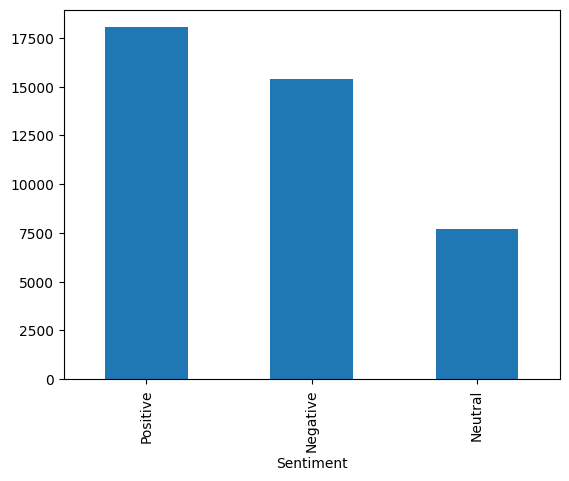

In [ ]:
df_train.Sentiment.value_counts().plot.bar()

Между Positive и Negative особенного дисбаланса нет, но в Neutral объектов сильно меньше. Но я подумала, что это весьма жизненно, так как чаще всего твит реального человека будет эмоционально окрашен в одну или другую сторону. Поэтому я не стала искуственно устранять этот дисбаланс.

<Axes: xlabel='Sentiment'>

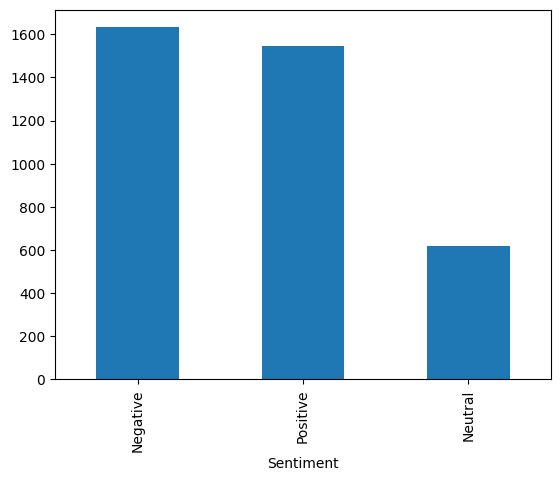

In [ ]:
df_test.Sentiment.value_counts().plot.bar()

In [ ]:
df_train.OriginalTweet.apply(lambda x: len(x.split())).describe()

,OriginalTweet
count,41157.000000
mean,18.461598
std,6.912316
min,0.000000
25%,13.000000
50%,19.000000
75%,24.000000
max,58.000000


<Axes: ylabel='Frequency'>

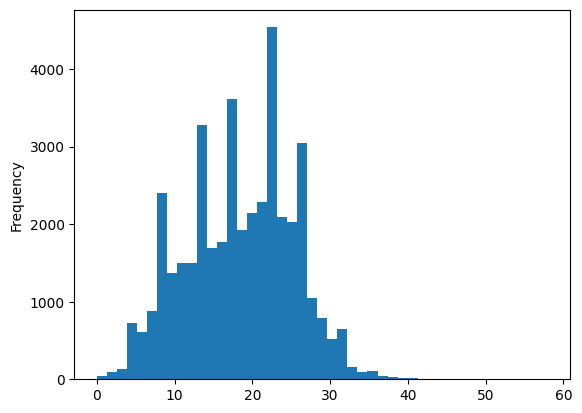

In [ ]:
df_train.OriginalTweet.apply(lambda x: len(x.split())).plot.hist(bins=45)

Типичный твит содержит 13–24 слова, максимальная длинна - 58. Однако, судя по гистограмме, твитов 50+ почти нет, большинство находится в пределах 15-25, а общее затухание идет где-то после 35.

Из всех моделей я выбрала и загрузила 'glove-wiki-gigaword-300', потому что она является наиболее универсальной для подобной задачи.

In [ ]:
list(api.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [ ]:
corpus = api.load('glove-wiki-gigaword-300')
corpus.vector_size

300

Разделим набор данных из тренировочных на train и validation, а тестовый набор данных оставим test.

In [ ]:
X = df_train['OriginalTweet']
y = df_train['Sentiment']

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
x_test = df_test['OriginalTweet']
y_test = df_test['Sentiment']

Перекодируем метки класса для удобства нейросетки

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

Создадим лемматизатор и токенизатор для использования его в нашем будущем классе, описывающим датасет.

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
tokenizer = nltk.RegexpTokenizer(r"\w+")
lemmatizer = nltk.WordNetLemmatizer()

tokenized = tokenizer.tokenize(x_train.iloc[0])
print(tokenized)
print([lemmatizer.lemmatize(word) for word in tokenized])

['unemployment', 'claims', 'made', 'online', 'virginia', 'week', 'monday', '426', 'tuesday', '2', '150', 'numbers', 'going', 'get', 'bigger']
['unemployment', 'claim', 'made', 'online', 'virginia', 'week', 'monday', '426', 'tuesday', '2', '150', 'number', 'going', 'get', 'bigger']


Воспользуемся готовым классом для создания кастомного датасета для обучения нашей нейросети. Он позволяет преобразовать текстовые данные в последовательности векторных представлений слов определенной, фикстрованной длинны.

In [ ]:
class CustomDataset(Dataset):
    """
    Класс CustomDataset предназначен для создания пользовательского датасета
    на основе текстовых данных с использованием векторных представлений слов (word2vec).

    Аргументы:
        texts (list): Список текстовых данных.
        labels (list): Список из меток класса, соответствующих текстам.
        word2vec_model: Модель word2vec для получения векторных представлений слов.
        max_length (int): Максимальная длина текста (количество слов), до которой
                         будут заполняться векторные представления.
        tokenizer (object, optional): Токенизатор для разбиения текста на слова.
        lemmatizer (object, optional): Лемматизатор для приведения слов к начальной форме.
    """
    def __init__(self, texts, labels, word2vec_model, max_length, tokenizer=tokenizer, lemmatizer=lemmatizer):
        """
        Инициализация датасета.

        Args:
            texts (list): Список текстовых данных.
            labels (list): Список меток, соответствующих текстам.
            word2vec_model: Модель word2vec для получения векторных представлений слов.
            max_length (int): Максимальная длина текста (количество слов), до которой
                             будут заполняться векторные представления.
            tokenizer (object, optional): Токенизатор для разбиения текста на слова.
            lemmatizer (object, optional): Лемматизатор для приведения слов к начальной форме.
        """
        self.texts = texts
        self.labels = labels
        self.word2vec_model = word2vec_model
        self.word2vec_dim = word2vec_model.vector_size
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.lemmatizer = lemmatizer

    def __len__(self):
        """
        Возвращает количество текстовых примеров в датасете.

        Returns:
            int: Количество текстовых примеров.
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Получает элемент данных по индексу.

        Args:
            idx (int): Индекс элемента в датасете.

        Returns:
            dict: Словарь с векторными представлениями слов и меткой.
                'word2vec_embeddings' (torch.Tensor): Тензор с векторными представлениями слов.
                'labels' (torch.Tensor): Тензор с меткой.
        """
        text = str(self.texts[idx]).lower()
        label = self.labels[idx]

        words = self.tokenizer.tokenize(text) # Токенизируем текст на слова
        words = [self.lemmatizer.lemmatize(word) for word in words] # Лемматизируем каждое слово

        # Получаем векторные представления слов и создаем вектор последовательности
        embeddings = [self.get_word_embedding(word) for word in words]

        # Если длина последовательности меньше максимальной длины, дополняем нулевыми векторами
        if len(embeddings) < self.max_length:
            embeddings.extend([torch.zeros(self.word2vec_dim, dtype=torch.float32)] * (self.max_length - len(embeddings)))
        else:
            embeddings = embeddings[:self.max_length] # Обрезаем до максимальной длины, если длина превышает максимум

        return {
            'word2vec_embeddings': torch.stack(embeddings),
            'labels': torch.tensor(label, dtype=torch.long)
        }

    def get_word_embedding(self, word):
        """
        Получает векторное представление слова с использованием word2vec_model.

        Args:
            word (str): Слово для получения векторного представления.

        Returns:
            torch.Tensor: Тензор с векторным представлением слова.
        """
        if word in self.word2vec_model:
            return torch.tensor(self.word2vec_model.get_vector(word), dtype=torch.float32)
        else:
            return torch.zeros(self.word2vec_dim, dtype=torch.float32)

Исходя из диаграммы выше, т.е. того факта, что твиты больше 35 символов - редкость, я выбрала это число в качестве макимальной длинны вектора в датасете. Подготовим их для максимально эффективного обучения с помощью DataLoader

In [ ]:
train_dataset = CustomDataset(x_train.tolist(), y_train.tolist(), corpus, 35)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

valid_dataset = CustomDataset(x_val.tolist(), y_val.tolist(), corpus, 35)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

test_dataset = CustomDataset(x_test.tolist(), y_test.tolist(), corpus, 35)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Создадим класс, инициализирующий рекурентую нейросеть для классфиикации твитов на три категории. Параметры модели, включая тип рекурентного слоя, метод агрегации выходов нейросети и функцию активации, можно изменять. Основная идея модели заключается в следующем:

    1. На вход подаются последовательности эмбеддингов слов фиксированной длины.
    2. Последовательность обрабатывается рекуррентным слоем выбранного типа.
    3. Выходы RNN агрегируются с помощью одного из методов pooling.
    4. Полученный вектор проходит через полносвязный классификатор.

In [ ]:
import torch.nn.functional as F

"""
Класс Word2VecRNNClassifier реализует модель нейронной сети для классификации текстов на основе рекуррентных архитектур
и заранее вычисленных векторных представлений слов.
"""

class Word2VecRNNClassifier(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        hidden_size=64,
        num_layers=1,
        bidirectional=False,
        dropout=0.3,
        rnn_type="RNN",       # RNN | LSTM | GRU
        pooling="last",       # last | mean | max
        fc_activation="relu"  # relu | gelu | leaky_relu
    ):
        super().__init__()

        self.pooling = pooling
        self.bidirectional = bidirectional
        self.hidden_size = hidden_size

        """
        Аргументы:
          input_size (int): Размер входного вектора (длина word embedding).
          output_size (int): Количество классов для классификации.
          hidden_size (int): Размер скрытого состояния рекуррентного слоя. Изменяемый параметр
          num_layers (int): Число слоёв в нейросети, также изменяемый параметр. При значении > 1 применяется dropout между слоями.
          bidirectional (bool): Использовать ли двунаправленную рекуррентную сеть. Позволяет учитывать контекст слева направо
                                и справа налево.
          dropout (float): Доля нейронов, которые отключаются во время обучения для уменьшения переобучения.
          rnn_type (str): Тип рекуррентного слоя (задается при инициализации из предложенных):
                        'RNN' — простая рекуррентная сеть,
                        'LSTM' — сеть с механизмом долгой краткосрочной памяти,
                        'GRU' — облегчённая версия LSTM.
          pooling (str): Метод агрегации выходов рекуррентного слоя (задается при инициализации из предложенных):
                       'last' — используется последнее скрытое состояние,
                       'mean' — усреднение всех состояний по времени,
                       'max' — max-pooling по временной оси.
          fc_activation (str): Функция активации для полносвязного классификатора (задается при инициализации из предложенных):
                             'relu', 'gelu', 'leaky_relu'.
        """

        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                bidirectional=bidirectional,
                dropout=dropout if num_layers > 1 else 0
            )
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                bidirectional=bidirectional,
                dropout=dropout if num_layers > 1 else 0
            )
        else:
            self.rnn = nn.RNN(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                nonlinearity="tanh",
                bidirectional=bidirectional,
                dropout=dropout if num_layers > 1 else 0
            )

        self.dropout = nn.Dropout(dropout)

        rnn_output_size = hidden_size * (2 if bidirectional else 1)

        if fc_activation.lower() == "relu":
            activation_fn = nn.ReLU()
        elif fc_activation.lower() == "gelu":
            activation_fn = nn.GELU()
        elif fc_activation.lower() == "leaky_relu":
            activation_fn = nn.LeakyReLU()
        else:
            raise ValueError(f"Unknown fc_activation: {fc_activation}")

        self.fc = nn.Sequential(
            nn.Linear(rnn_output_size, rnn_output_size // 2),
            activation_fn,
            nn.Dropout(dropout),
            nn.Linear(rnn_output_size // 2, output_size)
        )

    def forward(self, word2vec_embeddings):
        rnn_output, _ = self.rnn(word2vec_embeddings)

        # Pooling
        if self.pooling == "last":
            pooled = rnn_output[:, -1, :]
        elif self.pooling == "mean":
            pooled = rnn_output.mean(dim=1)
        elif self.pooling == "max":
            pooled, _ = torch.max(rnn_output, dim=1)
        else:
            raise ValueError("Unknown pooling type")

        pooled = self.dropout(pooled)
        logits = self.fc(pooled)
        return logits


Далее поступим следующим образом. Случайным образом я выбрала несколько конфигураций (последняя конфигурация была выбрана путем анализа результатов предыдущих) и попробовала обучить их на тренировочных данных и оценить на валидационных. В процессе тестирования я меняла только тип RNN, poooling и функцию активации. Тренировочный цикл я взяла готовый, обучение происходит на 10 эпохах, для оценки используется оценка F1 с average = macro.

**Конфигурации нейросетей**:

1. - Тип RNN: LSTM
   - Тип пулинга: mean
   - Функция активации: gelu
2. - Тип RNN: RNN
   - Тип пулинга: max
   - Функция активации: relu
3. - Тип RNN: GRU
   - Тип пулинга: mean
   - Функция активации: leaky_relu
4. - Тип RNN: GRU
   - Тип пулинга: mean
   - Функция активации: gelu

In [ ]:
model = Word2VecRNNClassifier(
    input_size=300,
    output_size=5,
    rnn_type="LSTM",
    bidirectional=True,
    hidden_size=128,
    num_layers=2,
    pooling="mean",
    fc_activation="gelu"
)

criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) # оптимизатор

model.to('cpu')
model.train()

Word2VecRNNClassifier(
  (rnn): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [ ]:
losses = {'train':[], 'valid':[]}

for epoch in range(10):
    loss_epoch = 0 # Переменная для накопления значения функции потерь в текущей эпохе
    print('-'*100)
    print(f'Training epoch:', epoch)
    for batch in train_loader: # Цикл по батчам данных для трейна

        word2vec_embeddings = batch['word2vec_embeddings'].to('cpu') # Получение векторных представлений слов
        labels = batch['labels'].to('cpu') # Получение меток классов

        logits = model(word2vec_embeddings) # Получение выходных логитов модели
        loss = criterion(logits, labels) # Вычисление функции потерь
        loss_epoch += loss.item() # Накопление значения функции потерь
        optimizer.zero_grad() # Обнуление градиентов
        loss.backward() # Обратное распространение ошибки
        optimizer.step() # Шаг оптимизатора для обновления параметров модели

    loss_epoch = loss_epoch / len(train_loader) # Получение средней функции потерь на эпохе
    losses['train'].append(loss_epoch)
    print(f'Epoch loss:', loss_epoch)

    model.eval() # Перевод модели в режим оценки (evaluation)
    with torch.no_grad():
        y_true = []
        y_pred = []

        for batch in valid_loader:
            word2vec_embeddings = batch['word2vec_embeddings'].to('cpu')
            labels = batch['labels'].to('cpu')

            logits = model(word2vec_embeddings)
            loss = criterion(logits, labels)
            loss_epoch += loss.item()
            predicted = torch.argmax(logits.data, 1) # Получение предсказанных классов

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    loss_epoch = loss_epoch / len(valid_loader)
    losses['valid'].append(loss_epoch)
    print(f'Valid loss:', loss_epoch)
    f1 = f1_score(y_true, y_pred, average='macro') # Вычисление F1-меры на валидационной выборке

    print(f'Valid F1 score on {epoch} epoch:', round(f1, 4))
    print('-'*100)

    model.train() # Перевод модели в режим обучения для следующей эпохи

----------------------------------------------------------------------------------------------------
Training epoch: 0
Epoch loss: 0.8949159861768333
Valid loss: 0.7537575150654029
Valid F1 score on 0 epoch: 0.6257
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training epoch: 1
Epoch loss: 0.7020329095784901
Valid loss: 0.6782779764126932
Valid F1 score on 1 epoch: 0.6914
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training epoch: 2
Epoch loss: 0.6453726317118672
Valid loss: 0.6477565714752574
Valid F1 score on 2 epoch: 0.7191
----------------------------------------------------------------------------------------------------
----------------------------------------------------

In [ ]:
model_rnn = Word2VecRNNClassifier(
    input_size=300,
    output_size=5,
    rnn_type="RNN",
    bidirectional=True,
    hidden_size=128,
    num_layers=2,
    pooling="max",
    fc_activation="relu"
)

criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=3e-3) # оптимизатор

model_rnn.to('cpu')
model_rnn.train()

Word2VecRNNClassifier(
  (rnn): RNN(300, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [ ]:
losses = {'train':[], 'valid':[]}

for epoch in range(10):
    loss_epoch = 0 # Переменная для накопления значения функции потерь в текущей эпохе
    print('-'*100)
    print(f'Training epoch:', epoch)
    for batch in train_loader: # Цикл по батчам данных для трейна

        word2vec_embeddings = batch['word2vec_embeddings'].to('cpu') # Получение векторных представлений слов
        labels = batch['labels'].to('cpu') # Получение меток классов

        logits = model_rnn(word2vec_embeddings) # Получение выходных логитов модели
        loss = criterion(logits, labels) # Вычисление функции потерь
        loss_epoch += loss.item() # Накопление значения функции потерь
        optimizer.zero_grad() # Обнуление градиентов
        loss.backward() # Обратное распространение ошибки
        optimizer.step() # Шаг оптимизатора для обновления параметров модели

    loss_epoch = loss_epoch / len(train_loader) # Получение средней функции потерь на эпохе
    losses['train'].append(loss_epoch)
    print(f'Epoch loss:', loss_epoch)

    model.eval() # Перевод модели в режим оценки (evaluation)
    with torch.no_grad():
        y_true = []
        y_pred = []

        for batch in valid_loader:
            word2vec_embeddings = batch['word2vec_embeddings'].to('cpu')
            labels = batch['labels'].to('cpu')

            logits = model_rnn(word2vec_embeddings)
            loss = criterion(logits, labels)
            loss_epoch += loss.item()
            predicted = torch.argmax(logits.data, 1) # Получение предсказанных классов

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    loss_epoch = loss_epoch / len(valid_loader)
    losses['valid'].append(loss_epoch)
    print(f'Valid loss:', loss_epoch)
    f1 = f1_score(y_true, y_pred, average='macro') # Вычисление F1-меры на валидационной выборке

    print(f'Valid F1 score on {epoch} epoch:', round(f1, 4))
    print('-'*100)

    model_rnn.train() # Перевод модели в режим обучения для следующей эпохи

----------------------------------------------------------------------------------------------------
Training epoch: 0
Epoch loss: 0.7385693952296544
Valid loss: 0.6675232430644541
Valid F1 score on 0 epoch: 0.7239
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training epoch: 1
Epoch loss: 0.6547974176198533
Valid loss: 0.6537556395103998
Valid F1 score on 1 epoch: 0.7361
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training epoch: 2
Epoch loss: 0.6295530480667225
Valid loss: 0.6249471542312535
Valid F1 score on 2 epoch: 0.7523
----------------------------------------------------------------------------------------------------
----------------------------------------------------

In [ ]:
model_gru = Word2VecRNNClassifier(
    input_size=300,
    output_size=5,
    rnn_type="GRU",
    bidirectional=True,
    hidden_size=128,
    num_layers=2,
    pooling="mean",
    fc_activation="leaky_relu"
)

criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.Adam(model_gru.parameters(), lr=3e-4) # оптимизатор

model_gru.to('cpu')
model_gru.train()

Word2VecRNNClassifier(
  (rnn): GRU(300, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [ ]:
losses = {'train':[], 'valid':[]}

for epoch in range(10):
    loss_epoch = 0 # Переменная для накопления значения функции потерь в текущей эпохе
    print('-'*100)
    print(f'Training epoch:', epoch)
    for batch in train_loader: # Цикл по батчам данных для трейна

        word2vec_embeddings = batch['word2vec_embeddings'].to('cpu') # Получение векторных представлений слов
        labels = batch['labels'].to('cpu') # Получение меток классов

        logits = model_gru(word2vec_embeddings) # Получение выходных логитов модели
        loss = criterion(logits, labels) # Вычисление функции потерь
        loss_epoch += loss.item() # Накопление значения функции потерь
        optimizer.zero_grad() # Обнуление градиентов
        loss.backward() # Обратное распространение ошибки
        optimizer.step() # Шаг оптимизатора для обновления параметров модели

    loss_epoch = loss_epoch / len(train_loader) # Получение средней функции потерь на эпохе
    losses['train'].append(loss_epoch)
    print(f'Epoch loss:', loss_epoch)

    model.eval() # Перевод модели в режим оценки (evaluation)
    with torch.no_grad():
        y_true = []
        y_pred = []

        for batch in valid_loader:
            word2vec_embeddings = batch['word2vec_embeddings'].to('cpu')
            labels = batch['labels'].to('cpu')

            logits = model_gru(word2vec_embeddings)
            loss = criterion(logits, labels)
            loss_epoch += loss.item()
            predicted = torch.argmax(logits.data, 1) # Получение предсказанных классов

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    loss_epoch = loss_epoch / len(valid_loader)
    losses['valid'].append(loss_epoch)
    print(f'Valid loss:', loss_epoch)
    f1 = f1_score(y_true, y_pred, average='macro') # Вычисление F1-меры на валидационной выборке

    print(f'Valid F1 score on {epoch} epoch:', round(f1, 4))
    print('-'*100)

    model_gru.train() # Перевод модели в режим обучения для следующей эпохи

----------------------------------------------------------------------------------------------------
Training epoch: 0
Epoch loss: 0.8350776381862973
Valid loss: 0.6961832334887249
Valid F1 score on 0 epoch: 0.6794
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training epoch: 1
Epoch loss: 0.6360331555593361
Valid loss: 0.6199755944179844
Valid F1 score on 1 epoch: 0.7404
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training epoch: 2
Epoch loss: 0.5789384185110481
Valid loss: 0.5948310891316188
Valid F1 score on 2 epoch: 0.7565
----------------------------------------------------------------------------------------------------
----------------------------------------------------

In [ ]:
model_gru_gelu = Word2VecRNNClassifier(
    input_size=300,
    output_size=5,
    rnn_type="GRU",
    bidirectional=True,
    hidden_size=128,
    num_layers=2,
    pooling="mean",
    fc_activation="gelu"
)

criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.Adam(model_gru_gelu.parameters(), lr=3e-4) # оптимизатор

model_gru_gelu.to('cpu')
model_gru_gelu.train()

Word2VecRNNClassifier(
  (rnn): GRU(300, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [ ]:
losses = {'train':[], 'valid':[]}

for epoch in range(10):
    loss_epoch = 0 # Переменная для накопления значения функции потерь в текущей эпохе
    print('-'*100)
    print(f'Training epoch:', epoch)
    for batch in train_loader: # Цикл по батчам данных для трейна

        word2vec_embeddings = batch['word2vec_embeddings'].to('cpu') # Получение векторных представлений слов
        labels = batch['labels'].to('cpu') # Получение меток классов

        logits = model_gru_gelu(word2vec_embeddings) # Получение выходных логитов модели
        loss = criterion(logits, labels) # Вычисление функции потерь
        loss_epoch += loss.item() # Накопление значения функции потерь
        optimizer.zero_grad() # Обнуление градиентов
        loss.backward() # Обратное распространение ошибки
        optimizer.step() # Шаг оптимизатора для обновления параметров модели

    loss_epoch = loss_epoch / len(train_loader) # Получение средней функции потерь на эпохе
    losses['train'].append(loss_epoch)
    print(f'Epoch loss:', loss_epoch)

    model.eval() # Перевод модели в режим оценки (evaluation)
    with torch.no_grad():
        y_true = []
        y_pred = []

        for batch in valid_loader:
            word2vec_embeddings = batch['word2vec_embeddings'].to('cpu')
            labels = batch['labels'].to('cpu')

            logits = model_gru_gelu(word2vec_embeddings)
            loss = criterion(logits, labels)
            loss_epoch += loss.item()
            predicted = torch.argmax(logits.data, 1) # Получение предсказанных классов

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    loss_epoch = loss_epoch / len(valid_loader)
    losses['valid'].append(loss_epoch)
    print(f'Valid loss:', loss_epoch)
    f1 = f1_score(y_true, y_pred, average='macro') # Вычисление F1-меры на валидационной выборке

    print(f'Valid F1 score on {epoch} epoch:', round(f1, 4))
    print('-'*100)

    model_gru_gelu.train() # Перевод модели в режим обучения для следующей эпохи

----------------------------------------------------------------------------------------------------
Training epoch: 0
Epoch loss: 0.8225962519067005
Valid loss: 0.6845245566936561
Valid F1 score on 0 epoch: 0.6927
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training epoch: 1
Epoch loss: 0.6360021555308
Valid loss: 0.6281184193883783
Valid F1 score on 1 epoch: 0.7364
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Training epoch: 2
Epoch loss: 0.5786645770072937
Valid loss: 0.6099878443766009
Valid F1 score on 2 epoch: 0.7416
----------------------------------------------------------------------------------------------------
-------------------------------------------------------

Итак, сделаем выводы по результатам обучения и тестам пока на валидационной выборке. Формально, хуже всего оказалась вторая моедль - я полагаю, это из-за ее простоты (обычная RNN + relu), а лучше всех последняя модель, в 8 эпоху обучения которой оценка f1 достигла 0.8. Однако, важно отметить, что все результаты достаточно близки друг к другу.

Сделаем функцию, которая будет оценивать наши модели по 4 параметрам на тестовых данных, в том числе F1 и посмотрим на результаты.

In [ ]:
def eval_models(modeltype):
  modeltype.eval()
  with torch.no_grad():
      y_true = []
      y_pred = []

      for batch in test_loader:
          word2vec_embeddings = batch['word2vec_embeddings'].to('cpu')
          labels = batch['labels'].to('cpu')

          logits = modeltype(word2vec_embeddings)
          predicted = torch.argmax(logits.data, 1)

          y_true.extend(labels.cpu().numpy())
          y_pred.extend(predicted.cpu().numpy())

  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  f1 = f1_score(y_true, y_pred, average='macro')
  print(f'Model name: {modeltype}')
  print(f"Test Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-score: {f1:.4f}")
  print(f'\n')

In [ ]:
eval_models(model)
eval_models(model_rnn)
eval_models(model_gru)
eval_models(model_gru_gelu)

Model name: Word2VecRNNClassifier(
  (rnn): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=5, bias=True)
  )
)
Test Accuracy: 0.7738
Precision: 0.7595
Recall: 0.7603
F1-score: 0.7592


Model name: Word2VecRNNClassifier(
  (rnn): RNN(300, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=5, bias=True)
  )
)
Test Accuracy: 0.7965
Precision: 0.7810
Recall: 0.7896
F1-score: 0.7848


Model name: Word2VecRNNClassifier(
  (rnn): GRU(300, 128, num_layers=2, batch_first=True, dropo

Итак, исходя из результатов на тестовых данных, по оценке f1 наиболее хорошей вообще оказалась 2 модель с RNN+max+relu, следующей - как раз последня: GRU+mean+gelu.

Вообще все модели соотвествуют требованиям заказчика в f1>0.7, однако, я думаю, что качество моделей можно улучшать путем изменения количества скрытых слоев и, например, размера скрытого состояния. Как мне показалось в ходе обучения и анализа наиболее удачной функцией активации в данном случае является gelu, а наиболее удачная архитектура рекурентной сети - GRU (если смотреть на эпохи обучения).